**Importing Files**

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, Dense
import itertools
import warnings
warnings.filterwarnings("ignore")

# Load Data
amzn_df = pd.read_csv("AMZN.csv", parse_dates=["Date"], index_col="Date")
jj_df = pd.read_csv("jj.csv", parse_dates=["date"], index_col="date")

**Inital Plotting**

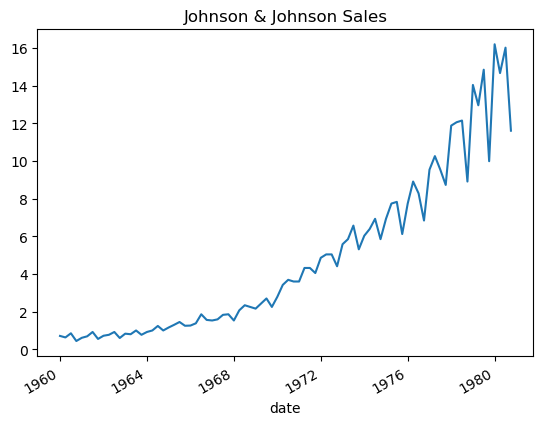

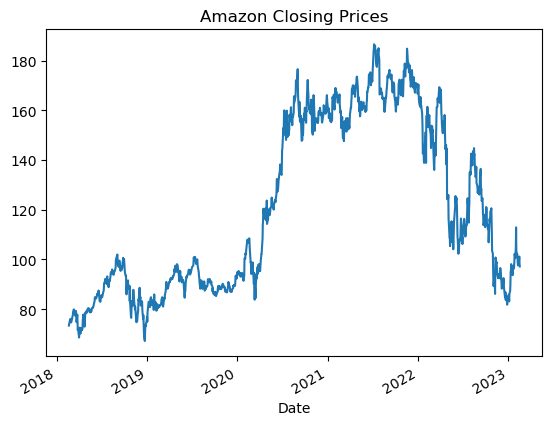

In [6]:
jj_df['data'].plot(title='Johnson & Johnson Sales')
plt.show()
amzn_df['Close'].plot(title='Amazon Closing Prices')
plt.show()

**Checking Data Stationary**

In [7]:
amzn_diff = amzn_df["Close"].diff().dropna()
jj_diff2 = jj_df["data"].diff().diff().dropna()
print("ADF p-value (AMZN 1st diff):", adfuller(amzn_diff)[1])
print("ADF p-value (JJ 2nd diff):", adfuller(jj_diff2)[1])

ADF p-value (AMZN 1st diff): 0.0
ADF p-value (JJ 2nd diff): 0.006051099869603033


**Implementing ARIMA**

In [8]:
def find_best_arima(series, max_p=4, max_d=2, max_q=4):
    best_aic = np.inf
    best_order = None
    best_model = None
    for p, d, q in itertools.product(range(max_p+1), range(max_d+1), range(max_q+1)):
        try:
            model = ARIMA(series, order=(p,d,q)).fit()
            if model.aic < best_aic:
                best_aic, best_order, best_model = model.aic, (p,d,q), model
        except:
            continue
    return best_order, best_model

amzn_order, amzn_arima = find_best_arima(amzn_df["Close"])
jj_order, jj_arima = find_best_arima(jj_df["data"])
print("AMZN ARIMA Order:", amzn_order)
print("JJ ARIMA Order:", jj_order)
amzn_arima_forecast = amzn_arima.forecast(steps=24)
jj_arima_forecast = jj_arima.forecast(steps=24)

AMZN ARIMA Order: (2, 1, 2)
JJ ARIMA Order: (3, 2, 4)


In [9]:
def train_and_forecast_rnn_fixed(data, model_type='LSTM', forecast_steps=24):
    scaler = MinMaxScaler()
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))

    def create_sequences(data, time_steps=12):
        X, y = [], []
        for i in range(len(data) - time_steps):
            X.append(data[i:i + time_steps])
            y.append(data[i + time_steps])
        return np.array(X), np.array(y)

    X, y = create_sequences(scaled_data)
    X = X.reshape(X.shape[0], X.shape[1], 1)

    model = Sequential()
    if model_type == 'LSTM':
        model.add(LSTM(64, activation='relu', input_shape=(X.shape[1], 1)))
    else:
        model.add(GRU(64, activation='relu', input_shape=(X.shape[1], 1)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X, y, epochs=50, batch_size=16, verbose=0)

    forecast_input = scaled_data[-12:].reshape(1, 12, 1)
    forecast = []

    for _ in range(forecast_steps):
        pred = model.predict(forecast_input, verbose=0)[0][0]
        forecast.append(pred)
        pred_reshaped = np.array(pred).reshape(1, 1, 1)
        forecast_input = np.concatenate((forecast_input[:, 1:, :], pred_reshaped), axis=1)

    return scaler.inverse_transform(np.array(forecast).reshape(-1, 1)).flatten()

**Implementing LSTM and GRU**

In [10]:
amzn_data = amzn_df["Close"].values
jj_data = jj_df["data"].values

amzn_lstm = train_and_forecast_rnn_fixed(amzn_data, model_type='LSTM')
amzn_gru = train_and_forecast_rnn_fixed(amzn_data, model_type='GRU')
jj_lstm = train_and_forecast_rnn_fixed(jj_data, model_type='LSTM')
jj_gru = train_and_forecast_rnn_fixed(jj_data, model_type='GRU')

**Plotting Final Result**

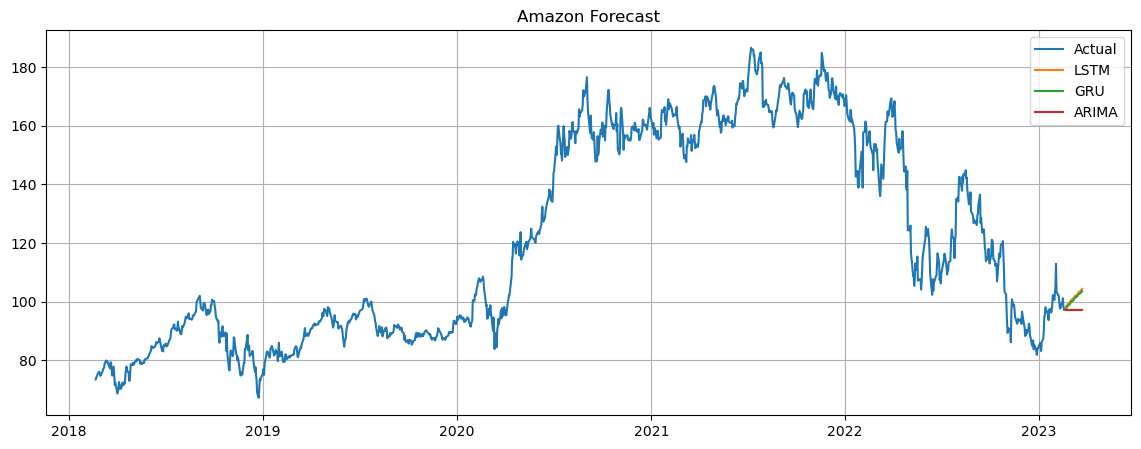

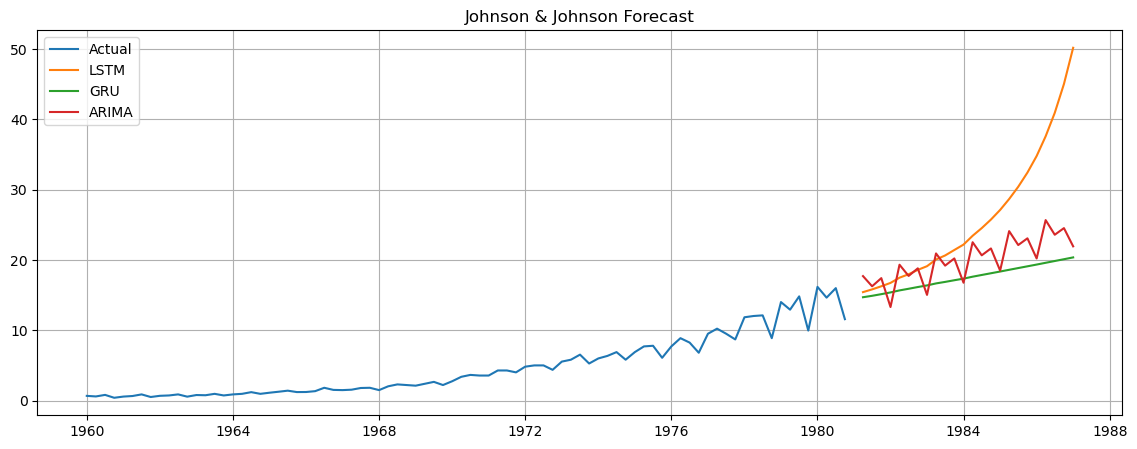

In [11]:
amzn_idx = pd.date_range(start=amzn_df.index[-1], periods=25, freq='B')[1:]
jj_idx = pd.date_range(start=jj_df.index[-1], periods=25, freq='Q')[1:]

plt.figure(figsize=(14,5))
plt.plot(amzn_df["Close"], label='Actual')
plt.plot(amzn_idx, amzn_lstm, label='LSTM')
plt.plot(amzn_idx, amzn_gru, label='GRU')
plt.plot(amzn_idx, amzn_arima_forecast, label='ARIMA')
plt.legend()
plt.title("Amazon Forecast")
plt.grid(True)
plt.show()

plt.figure(figsize=(14,5))
plt.plot(jj_df["data"], label='Actual')
plt.plot(jj_idx, jj_lstm, label='LSTM')
plt.plot(jj_idx, jj_gru, label='GRU')
plt.plot(jj_idx, jj_arima_forecast, label='ARIMA')
plt.legend()
plt.title("Johnson & Johnson Forecast")
plt.grid(True)
plt.show()

**Evaluation Metrics**

In [12]:
def evaluate(true, pred):
    mse = mean_squared_error(true, pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(true, pred)
    return round(mse, 4), round(rmse, 4), round(mae, 4)

amzn_true = amzn_df["Close"].values[-24:]
jj_true = jj_df["data"].values[-24:]

results = {
    "AMZN_ARIMA": evaluate(amzn_true, amzn_arima_forecast),
    "AMZN_LSTM": evaluate(amzn_true, amzn_lstm[:24]),
    "AMZN_GRU": evaluate(amzn_true, amzn_gru[:24]),
    "JJ_ARIMA": evaluate(jj_true, jj_arima_forecast),
    "JJ_LSTM": evaluate(jj_true, jj_lstm[:24]),
    "JJ_GRU": evaluate(jj_true, jj_gru[:24])
}
results_df = pd.DataFrame(results, index=["MSE", "RMSE", "MAE"]).T
print(results_df)

                 MSE     RMSE      MAE
AMZN_ARIMA   22.3367   4.7262   3.2764
AMZN_LSTM    16.4471   4.0555   3.2100
AMZN_GRU     14.8629   3.8552   2.9612
JJ_ARIMA     91.4631   9.5636   9.4990
JJ_LSTM     292.8701  17.1134  15.3814
JJ_GRU       51.4295   7.1714   6.9496
